<a href="https://colab.research.google.com/github/kazars24/mfdp-emotion-detection/blob/main/course%20modules/4.Improving%20models/experiments_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Модуль 4. Улучшение модели (версия 2)

В данном ноутбуке я подготовил несколько моделей и сравнил их по точности и скорости работы.

**Детекция лица на изображении.** Для этой задачи были использованы:
1. MTCNN из библиотеки facenet_pytorch;
2. MTCNN из библиотеки fer;
3. каскад Хаара из библиотеки fer;
4. YOLOv8.

**Распознавание эмоций.**Были рассмотрены следующие модели:


1.   InceptionResnetV1(pretrained='vggface2') с файнтюнингом на RAF Face Database;
2. InceptionResnetV1(pretrained='casia-webface') с файнтюнингом на RAF Face Database;
3. InceptionResnetV1 с обучением на RAF Face Database.

Проверка моделей осуществлялась на тестовой части датасета [RAF Face Database](http://www.whdeng.cn/raf/model1.html).

Используемый инструменты версионирования экспериментов - clearML.


## Установка и импорт библиотек

In [ ]:
!pip install torcheval
!pip install facenet_pytorch
!pip install clearml
!pip install FER
!pip install -U torchmetrics
!pip install pybboxes
!pip install ultralytics

In [ ]:
import os
import pandas as pd
import pickle
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageDraw
from google.colab.patches import cv2_imshow
import shutil
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR, ExponentialLR
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid

from facenet_pytorch import MTCNN, InceptionResnetV1, training
from fer import FER
from ultralytics import YOLO
import pybboxes as pbx

from clearml import Task, Logger

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.2)

## Загузка и подготовка данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!unzip /content/drive/MyDrive/raf_face_dataset/original.zip -d /content/raf_face_original/

In [ ]:
!unzip /content/drive/MyDrive/raf_face_dataset/boundingbox.zip -d /content/raf_face_bbox/

In [ ]:
with open('/content/drive/MyDrive/raf_face_dataset/list_patition_label.txt') as file:
    #lines = [line.rstrip() for line in file if 'test_' in line]
    train_img_files = []
    test_img_files = []
    for line in file:
        if 'train_' in line:
            name, label = line.rstrip().split(' ')
            train_img_files.append([name, int(label)])
        if 'test_' in line:
            name, label = line.rstrip().split(' ')
            test_img_files.append([name, int(label)])

assert len(train_img_files) + len(test_img_files) == 15339, "Smth is wrong"

In [ ]:
def iou(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

## Детекция лиц

Все модели сравнивались по нескольким показателям:
1. среднее время работы алгорима;
2. среднее значение IoU;
3. кол-во лиц, которых не удалось распознать.

Такой подход позволил проанализировать полученные результаты и выбрать наиболее оптимальную модель.

### MTCNN из библиотеки facenet_pytorch

In [ ]:
mtcnn = MTCNN(keep_all=True, device=device).eval()

In [ ]:
time_per_img = []
iou_scores = []
no_f_count = 0

for item in test_img_files:
    img_name = '/content/raf_face_original/original/' + item[0]
    bbox_name = '/content/raf_face_bbox/boundingbox/' + item[0][:-4] + '_boundingbox.txt'
    with Image.open(img_name) as img:
        img.load()
    with open(bbox_name) as file:
        for line in file:
            bbox_true = list(map(float, line.rstrip().split(' ')))

    start_time = time.time()
    bbox_pred, _ = mtcnn.detect(img)
    time_per_img.append(time.time() - start_time)
    try:
        bbox_pred = bbox_pred[0]
        iou_scores.append(iou(bbox_true, bbox_pred))
    except:
        iou_scores.append(0)
        no_f_count += 1

print("MTCNN facenet_pytorch")
print(f"Размер выборки: {len(test_img_files)}")
print(f"Не найдено лиц: {no_f_count} ({no_f_count / len(test_img_files) * 100}%)")
print(f"Ср. время: {sum(time_per_img) / len(time_per_img)}")
print(f"Ср. IoU: {sum(iou_scores) / len(iou_scores)}")

MTCNN facenet_pytorch
Размер выборки: 3068
Не найдено лиц: 77 (2.509778357235984%)
Ср. время: 0.1817269340021514
Ср. IoU: 0.8231199845247715


### MTCNN из библиотеки fer

In [ ]:
detector = FER(mtcnn=True)

In [ ]:
time_per_img = []
iou_scores = []
no_f_count = 0

for item in test_img_files:
    img_name = '/content/raf_face_original/original/' + item[0]
    bbox_name = '/content/raf_face_bbox/boundingbox/' + item[0][:-4] + '_boundingbox.txt'
    img = cv2.imread(img_name)
    with open(bbox_name) as file:
        for line in file:
            bbox_true = list(map(float, line.rstrip().split(' ')))
    start_time = time.time()
    face_bbox = detector.find_faces(img)
    time_per_img.append(time.time() - start_time)
    try:
        bbox_pred = [face_bbox[0][0],
                     face_bbox[0][1],
                     face_bbox[0][2] + face_bbox[0][0],
                     face_bbox[0][3] + face_bbox[0][1]
                     ]
        iou_scores.append(iou(bbox_true, bbox_pred))
    except:
        iou_scores.append(0)
        no_f_count += 1

print("FER(mtcnn=True)")
print(f"Размер выборки: {len(test_img_files)}")
print(f"Не найдено лиц: {no_f_count} ({no_f_count / len(test_img_files) * 100}%)")
print(f"Ср. время: {sum(time_per_img) / len(time_per_img)}")
print(f"Ср. IoU: {sum(iou_scores) / len(iou_scores)}")

FER(mtcnn=True)
Размер выборки: 3068
Не найдено лиц: 427 (13.917861799217732%)
Ср. время: 0.22796306655180035
Ср. IoU: 0.7192383859234843


### Каскад Хаара из библиотеки fer

In [ ]:
detector = FER(mtcnn=False)

time_per_img = []
iou_scores = []
no_f_count = 0

for item in test_img_files:
    img_name = '/content/raf_face_original/original/' + item[0]
    bbox_name = '/content/raf_face_bbox/boundingbox/' + item[0][:-4] + '_boundingbox.txt'
    img = cv2.imread(img_name)
    with open(bbox_name) as file:
        for line in file:
            bbox_true = list(map(float, line.rstrip().split(' ')))

    start_time = time.time()
    face_bbox = detector.find_faces(img)
    time_per_img.append(time.time() - start_time)

    try:
        bbox_pred = [face_bbox[0][0],
                     face_bbox[0][1],
                     face_bbox[0][2] + face_bbox[0][0],
                     face_bbox[0][3] + face_bbox[0][1]
                     ]
        iou_scores.append(iou(bbox_true, bbox_pred))
    except:
        iou_scores.append(0)
        no_f_count += 1


print("FER(mtcnn=False)")
print(f"Размер выборки: {len(test_img_files)}")
print(f"Не найдено лиц: {no_f_count} ({no_f_count / len(test_img_files) * 100}%)")
print(f"Ср. время: {sum(time_per_img) / len(time_per_img)}")
print(f"Ср. IoU: {sum(iou_scores) / len(iou_scores)}")

FER(mtcnn=False)
Размер выборки: 3068
Не найдено лиц: 643 (20.958279009126468%)
Ср. время: 0.10457187852150769
Ср. IoU: 0.512306967019732


### YOLOv8

#### Подготовка данных для обучения

In [ ]:
!mkdir raf_dataset

In [ ]:
!mkdir raf_dataset/images

In [ ]:
!mkdir raf_dataset/labels

In [ ]:
!mkdir raf_dataset/images/train

In [ ]:
!mkdir raf_dataset/images/val

In [ ]:
!mkdir raf_dataset/labels/train

In [ ]:
!mkdir raf_dataset/labels/val

In [ ]:
img_from_dir = '/content/raf_face_original/original/'
bbox_from_dir = '/content/raf_face_bbox/boundingbox/'
img_to_dir_train = '/content/raf_dataset/images/train/'
label_to_dir_train = '/content/raf_dataset/labels/train/'
img_to_dir_val = '/content/raf_dataset/images/val/'
label_to_dir_val = '/content/raf_dataset/labels/val/'

with open('/content/drive/MyDrive/raf_face_dataset/list_patition_label.txt') as file:
    for line in tqdm(file):
        img_name, _ = line.rstrip().split(' ')
        old_img_path = img_from_dir + img_name
        old_bbox_path = bbox_from_dir + img_name[:-4] + '_boundingbox.txt'
        if 'train_' in line:
            new_img_path = img_to_dir_train + img_name
            new_label_path = label_to_dir_train + img_name.split('.')[0] + '.txt'
        if 'test_' in line:
            new_img_path = img_to_dir_val + img_name
            new_label_path = label_to_dir_val + img_name.split('.')[0] + '.txt'
        with Image.open(old_img_path) as img:
            img.load()
        width, height = img.size
        with open(old_bbox_path) as file:
            for line in file:
                bbox_true = list(map(float, line.rstrip().split(' ')))
        bbox_true_yolo = pbx.convert_bbox(bbox_true, from_type="voc", to_type="yolo", image_size=(width, height))
        new_label = f"0 {bbox_true_yolo[0]} {bbox_true_yolo[1]} {bbox_true_yolo[2]} {bbox_true_yolo[3]}"
        #shutil.move(old_img_path, new_img_path, copy_function = shutil.copytree)
        img.save(new_img_path)
        with open(new_label_path, "w") as f:
            for line in new_label:
                f.write(line)


0it [00:00, ?it/s]

#### Обучение модели

In [ ]:
%env CLEARML_WEB_HOST=https://app.clear.ml
%env CLEARML_API_HOST=https://api.clear.ml
%env CLEARML_FILES_HOST=https://files.clear.ml
%env CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI
%env CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI

env: CLEARML_WEB_HOST=https://app.clear.ml
env: CLEARML_API_HOST=https://api.clear.ml
env: CLEARML_FILES_HOST=https://files.clear.ml
env: CLEARML_API_ACCESS_KEY=F6KM2HNXU0U5VQ0GYLTI
env: CLEARML_API_SECRET_KEY=9SY1dPWOn0NrS2Fwwlalh6HPEaSxhtr0FNbB1KW8py7SB5EKLI


In [ ]:
!clearml-init

In [ ]:
#task.close()
task = Task.init(
    project_name='Emotion detection',
    task_name='yolov8n_raf_e10_b64',
    tags=['yolov8n'])

In [ ]:
model = YOLO('yolov8n.pt')

2023-06-22 10:51:16,225 - clearml.model - INFO - Selected model id: d546609ce21e421cb13c8915ad454d1e


Ultralytics YOLOv8.0.121 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=raf.yaml, epochs=10, patience=50, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8n_raf_e10_b64, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=Fa

2023-06-22 11:48:51,423 - clearml.Task - INFO - Completed model upload to https://files.clear.ml/Emotion%20detection/yolov8n_raf_e10_b64.f8c0f0cfccf748488ef323c048f0c974/models/best.pt


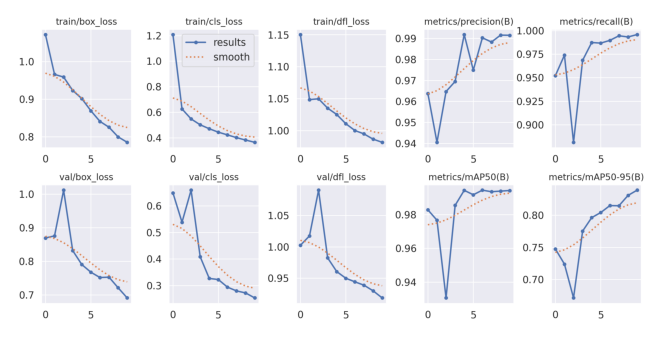

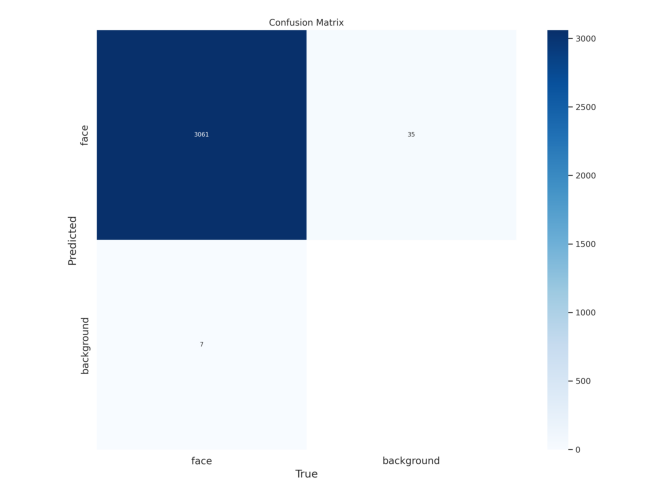

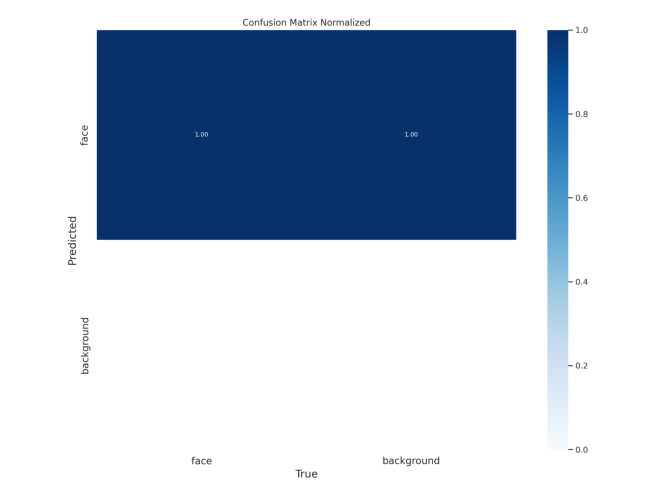

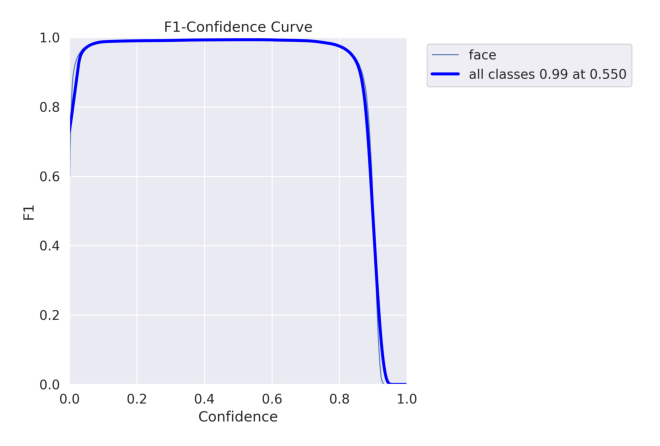

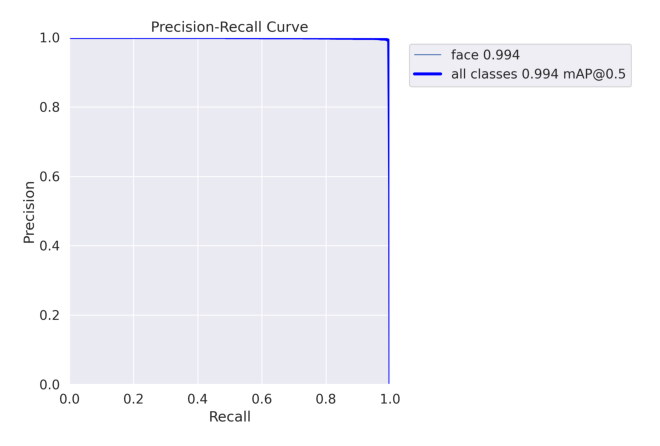

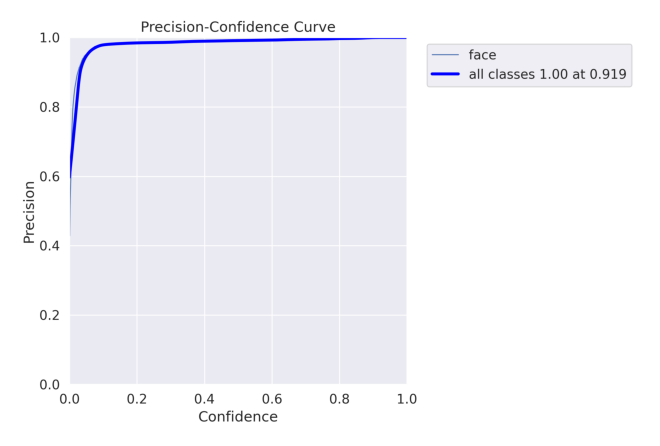

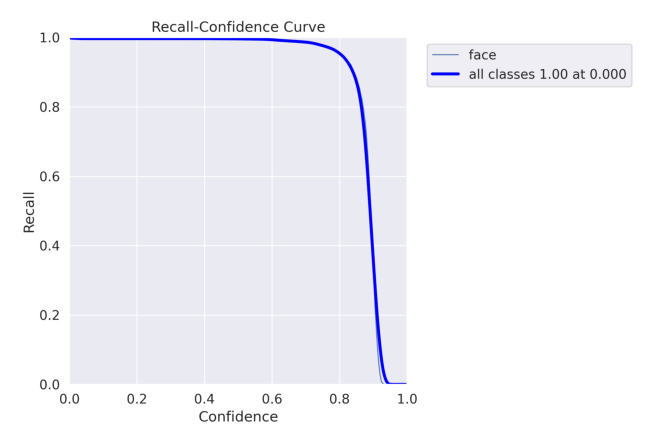

In [ ]:
model.train(data='raf.yaml', epochs=10, batch=64, name='yolov8n_raf_e10_b64')

In [ ]:
#task.close()

#### Тестирование

Теперь проверим обученную YOLOv8 на тестовой части нашего датасета

In [ ]:
model = YOLO('best.pt')

In [ ]:
for item in test_img_files:
    img_name = '/content/raf_face_original/original/' + item[0]
    bbox_name = '/content/raf_face_bbox/boundingbox/' + item[0][:-4] + '_boundingbox.txt'
    with open(bbox_name) as file:
        for line in file:
            bbox_true = list(map(float, line.rstrip().split(' ')))
    print(bbox_true)
    results = model.predict(source=img_name, device=device, max_det=1, save=True)
    for result in results:
        boxes = result.boxes.xyxy
    print(boxes)
    break


image 1/1 /content/raf_face_original/original/test_0001.jpg: 640x448 1 face, 9.2ms
Speed: 4.9ms preprocess, 9.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


[153.84108, 130.382935, 327.412231, 355.140106]
tensor([[150.8670, 134.5531, 319.5612, 352.9557]], device='cuda:0')


In [ ]:
time_per_img = []
iou_scores = []
no_f_count = 0

for item in test_img_files:
    img_name = '/content/raf_face_original/original/' + item[0]
    bbox_name = '/content/raf_face_bbox/boundingbox/' + item[0][:-4] + '_boundingbox.txt'
    with open(bbox_name) as file:
        for line in file:
            bbox_true = list(map(float, line.rstrip().split(' ')))

    start_time = time.time()
    results = model.predict(source=img_name, device=device, max_det=1)
    for result in results:
        boxes = result.boxes.xyxy
    time_per_img.append(time.time() - start_time)
    if boxes.nelement() != 0:
        bbox_pred = boxes[0].cuda().tolist()
        iou_scores.append(iou(bbox_true, bbox_pred))
    elif boxes.nelement() == 0:
        iou_scores.append(0)
        no_f_count += 1

print("YOLOv8n")
print(f"Размер выборки: {len(test_img_files)}")
print(f"Не найдено лиц: {no_f_count} ({no_f_count / len(test_img_files) * 100}%)")
print(f"Ср. время: {sum(time_per_img) / len(time_per_img)}")
print(f"Ср. IoU: {sum(iou_scores) / len(iou_scores)}")

YOLOv8n

Размер выборки: 3068

Не найдено лиц: 1 (0.03259452411994785%)

Ср. время: 0.030837816629447092

Ср. IoU: 0.8998991150169982

Выводится очень много логов, поэтому я их удалил а результаты вынес в отдельную Markdown ячейку.

### Вывод

YOLOv8n показала себя лучше других по всем показателям, поэтому этот вариант и возьмем для детекции лиц!

## Классификатор эмоций

Теперь выберем классификатор

### Загрузка и подготовка данных

In [ ]:
!unzip /content/drive/MyDrive/raf_face_dataset/aligned.zip -d /content/raf_face_aligned/

In [ ]:
raf_labels = {
    1: 'surprise',
    2: 'fear',
    3: 'disgust',
    4: 'happy',
    5: 'sad',
    6: 'angry',
    7: 'neutral',
}

In [ ]:
!mkdir train

In [ ]:
!mkdir valid

In [ ]:
#!rm -rf train valid

In [ ]:
for folder in [train_img_files, test_img_files]:
    for item in tqdm(folder):
        img_name, label = item
        old_dir_path = '/content/raf_face_aligned/aligned/' + img_name[:-4] + '_aligned.jpg'
        if 'train_' in img_name:
            new_dir = f"/content/train/{raf_labels[label]}"
            new_dir_path = f"/content/train/{raf_labels[label]}/{img_name[:-4]}_aligned.jpg"
        if 'test_' in img_name:
            new_dir = f"/content/valid/{raf_labels[label]}"
            new_dir_path = f"/content/valid/{raf_labels[label]}/{img_name[:-4]}_aligned.jpg"
        if not os.path.exists(new_dir):
            os.makedirs(new_dir)
        with Image.open(old_dir_path) as img:
            img.load()
        img.save(new_dir_path)


  0%|          | 0/12271 [00:00<?, ?it/s]

  0%|          | 0/3068 [00:00<?, ?it/s]

In [ ]:
t_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
t_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

In [ ]:
train_dataset = datasets.ImageFolder(root='train', transform=t_train)
valid_dataset = datasets.ImageFolder(root='valid', transform=t_val)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=2)
val_loader = DataLoader(valid_dataset, batch_size=256, shuffle=False, num_workers=2)

In [ ]:
new_raf_labels = {
    0: 'surprise',
    1: 'fear',
    2: 'disgust',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'neutral',
}

### Подбор оптимальной модели InceptionResnetV1

#### InceptionResnetV1(pretrained='vggface2')

In [ ]:
resnet = InceptionResnetV1(
    classify=True,
    pretrained='vggface2',
    num_classes=7).to(device)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [4, 8, 10])
loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
epochs = 12

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet.eval()
training.pass_epoch(
    resnet, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet.train()
    training.pass_epoch(
        resnet, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet.eval()
    training.pass_epoch(
        resnet, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    24/24   | loss:    3.1680 | fps:  986.6985 | acc:    0.1394   

Epoch 1/12
----------
Train |    96/96   | loss:    0.9759 | fps:  613.9241 | acc:    0.6657   
Valid |    24/24   | loss:    0.7380 | fps: 1441.7354 | acc:    0.7413   

Epoch 2/12
----------
Train |    96/96   | loss:    0.6788 | fps:  613.0696 | acc:    0.7647   
Valid |    24/24   | loss:    0.6679 | fps: 1138.8964 | acc:    0.7786   

Epoch 3/12
----------
Train |    96/96   | loss:    0.5566 | fps:  609.2182 | acc:    0.8099   
Valid |    24/24   | loss:    0.6313 | fps: 1452.9604 | acc:    0.7870   

Epoch 4/12
----------
Train |    96/96   | loss:    0.4705 | fps:  587.1344 | acc:    0.8362   
Valid |    24/24   | loss:    0.5817 | fps: 1396.1699 | acc:    0.8132   

Epoch 5/12
----------
Train |    96/96   | loss:    0.3188 | fps:  625.4083 | acc:    0.8929   
Valid |    24/24   | loss:    0.4783 | fps: 1119.3749 | acc:    0.8504   

Epoch 6/12
----------
Train |    96/96   | loss: 

**1 вариант**
```
t_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
t_val = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
```


```
resnet = InceptionResnetV1(classify=True,pretrained='vggface2', num_classes=7).to(device)
```


```
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10])
```
Epoch 15/15

Train |    96/96   | loss:    0.0040 | fps:  617.9979 | acc:    0.9997

Valid |    24/24   | loss:    0.7074 | fps: 1401.7793 | acc:    0.8478


---

**2 вариант**

Тоже самое, только


```
t_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
t_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
```
Epoch 15/15

Train |    96/96   | loss:    0.0050 | fps:  619.4705 | acc:    0.9996

Valid |    24/24   | loss:    0.6863 | fps:  796.3889 | acc:    0.8472



---
**3 вариант**


```
t_train = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
t_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
```


```
resnet = InceptionResnetV1(classify=True, pretrained='vggface2', num_classes=7).to(device)
```


```
optimizer = optim.Adam(resnet.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [4, 8, 10])
loss_fn = torch.nn.CrossEntropyLoss()
```
Epoch 12/12

Train |    96/96   | loss:    0.0874 | fps:  579.7142 | acc:    0.9725

Valid |    24/24   | loss:    0.5705 | fps:  961.9649 | acc:    0.8537

#### InceptionResnetV1(pretrained='casia-webface')

In [ ]:
#task.close()
task = Task.init(
    project_name='Emotion detection',
    task_name='resnet_casiawebface_gray',
    tags=['resnet'])

In [ ]:
resnet_v2 = InceptionResnetV1(
    classify=True,
    pretrained='casia-webface',
    num_classes=7).to(device)

  0%|          | 0.00/111M [00:00<?, ?B/s]

2023-06-28 13:30:11,551 - clearml.model - INFO - Selected model id: caf2ea6c68104bb78034001f56a4d248


In [ ]:
optimizer = optim.Adam(resnet_v2.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [4, 8, 10])

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
epochs = 12

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet_v2.eval()
training.pass_epoch(
    resnet_v2, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet_v2.train()
    training.pass_epoch(
        resnet_v2, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_v2.eval()
    training.pass_epoch(
        resnet_v2, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    12/12   | loss:    3.2181 | fps: 1413.7949 | acc:    0.1420   

Epoch 1/12
----------
Train |    48/48   | loss:    0.9405 | fps:  622.2289 | acc:    0.6792   
Valid |    12/12   | loss:    0.9442 | fps: 1278.4166 | acc:    0.7231   

Epoch 2/12
----------
Train |    48/48   | loss:    0.5977 | fps:  640.8105 | acc:    0.7917   
Valid |    12/12   | loss:    0.5973 | fps: 1776.0688 | acc:    0.8044   

Epoch 3/12
----------
Train |    48/48   | loss:    0.4852 | fps:  612.9888 | acc:    0.8334   
Valid |    12/12   | loss:    0.6342 | fps: 1586.7374 | acc:    0.7861   

Epoch 4/12
----------
Train |    48/48   | loss:    0.4442 | fps:  631.1499 | acc:    0.8523   
Valid |    12/12   | loss:    0.6610 | fps: 1431.8828 | acc:    0.7964   

Epoch 5/12
----------
Train |    48/48   | loss:    0.2843 | fps:  605.8183 | acc:    0.9075   
Valid |    12/12   | loss:    0.4681 | fps: 1213.2070 | acc:    0.8452   

Epoch 6/12
----------
Train |    48/48   | loss: 

In [ ]:
pkl_filename = 'resnet_casiawebface_gray.pkl'
with open(pkl_filename, 'wb') as file:
    pickle.dump(resnet_v2.cpu(), file)

**1 вариант**




```
t_train = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
t_val = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
```


```
optimizer = optim.Adam(resnet_v2.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [4, 8, 10])
```
Epoch 12/12

Train |    48/48   | loss:    0.0962 | fps:  606.1890 | acc:    0.9706

Valid |    12/12   | loss:    0.5098 | fps: 1609.1836 | acc:    0.8576


---

**2 вариант**


```
optimizer = optim.Adam(resnet_v2.parameters(), lr=0.3e-4)
scheduler = MultiStepLR(optimizer, [4, 8, 10, 12])
```
Epoch 15/15

Train |    96/96   | loss:    0.1672 | fps:  589.3201 | acc:    0.9534

Valid |    24/24   | loss:    0.5227 | fps: 1365.2736 | acc:    0.8374


#### InceptionResnetV1 с обучением на RAF Face Database

In [ ]:
resnet_v3 = InceptionResnetV1(
    classify=True,
    pretrained=None,
    num_classes=7).to(device)

In [ ]:
optimizer = optim.Adam(resnet_v3.parameters(), lr=0.001)
scheduler = MultiStepLR(optimizer, [5, 10, 15])

loss_fn = torch.nn.CrossEntropyLoss()
metrics = {
    'fps': training.BatchTimer(),
    'acc': training.accuracy
}

In [ ]:
epochs = 20

writer = SummaryWriter()
writer.iteration, writer.interval = 0, 10

print('\n\nInitial')
print('-' * 10)
resnet_v3.eval()
training.pass_epoch(
    resnet_v3, loss_fn, val_loader,
    batch_metrics=metrics, show_running=True, device=device,
    writer=writer
)

for epoch in range(epochs):
    print('\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)

    resnet_v3.train()
    training.pass_epoch(
        resnet_v3, loss_fn, train_loader, optimizer, scheduler,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

    resnet_v3.eval()
    training.pass_epoch(
        resnet_v3, loss_fn, val_loader,
        batch_metrics=metrics, show_running=True, device=device,
        writer=writer
    )

writer.close()



Initial
----------
Valid |    24/24   | loss:    1.9544 | fps: 1393.0363 | acc:    0.0527   

Epoch 1/20
----------
Train |    96/96   | loss:    1.6892 | fps:  638.3727 | acc:    0.4282   
Valid |    24/24   | loss:    1.3226 | fps:  852.9870 | acc:    0.5359   

Epoch 2/20
----------
Train |    96/96   | loss:    1.1731 | fps:  629.6318 | acc:    0.5884   
Valid |    24/24   | loss:    1.1424 | fps: 1382.5436 | acc:    0.6232   

Epoch 3/20
----------
Train |    96/96   | loss:    0.9521 | fps:  609.2770 | acc:    0.6612   
Valid |    24/24   | loss:    0.8568 | fps: 1154.0612 | acc:    0.6972   

Epoch 4/20
----------
Train |    96/96   | loss:    0.8237 | fps:  617.3022 | acc:    0.7064   
Valid |    24/24   | loss:    0.8056 | fps: 1437.5455 | acc:    0.7171   

Epoch 5/20
----------
Train |    96/96   | loss:    0.7456 | fps:  582.6738 | acc:    0.7377   
Valid |    24/24   | loss:    1.4541 | fps: 1369.4502 | acc:    0.6624   

Epoch 6/20
----------
Train |    96/96   | loss: 

### Вывод

По метрикам лучшей оказалась модель InceptionResnetV1(pretrained='casia-webface'), для обучения которой использовалось:
1. 12 эпох;
2. optimizer = optim.Adam(resnet_v2.parameters(), lr=0.001);
3. scheduler = MultiStepLR(optimizer, [4, 8, 10]).

### Матрица ошибок

Для выбранной модели классификации эмоций построим матрицу ошибок. Она хорошо покажет, в каких эмоциях модель путается, а какие определяет уверенно.

In [ ]:
new_raf_labels = {
    0: 'angry',
    1: 'disgust',
    2: 'fear',
    3: 'happy',
    4: 'neutral',
    5: 'sad',
    6: 'surprise'
}

In [ ]:
y_true = []
y_pred = []
face_transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
resnet_v2 = resnet_v2.to(device).eval()

for item in tqdm(test_img_files):
    img_name = item[0]
    img_path = '/content/raf_face_aligned/aligned/' + img_name[:-4] + '_aligned.jpg'
    true_lbl = raf_labels[item[1]]
    y_true.append(true_lbl)
    with Image.open(img_path) as img:
        img.load()
    face = face_transform(img)
    face = face.to(device)
    face = torch.unsqueeze(face, 0)
    pred_class = int(torch.argmax(resnet_v2(face), dim=1))
    pred_label = new_raf_labels[pred_class]
    y_pred.append(pred_label)

  0%|          | 0/3068 [00:00<?, ?it/s]

In [ ]:
c_mat = confusion_matrix(y_true, y_pred, labels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

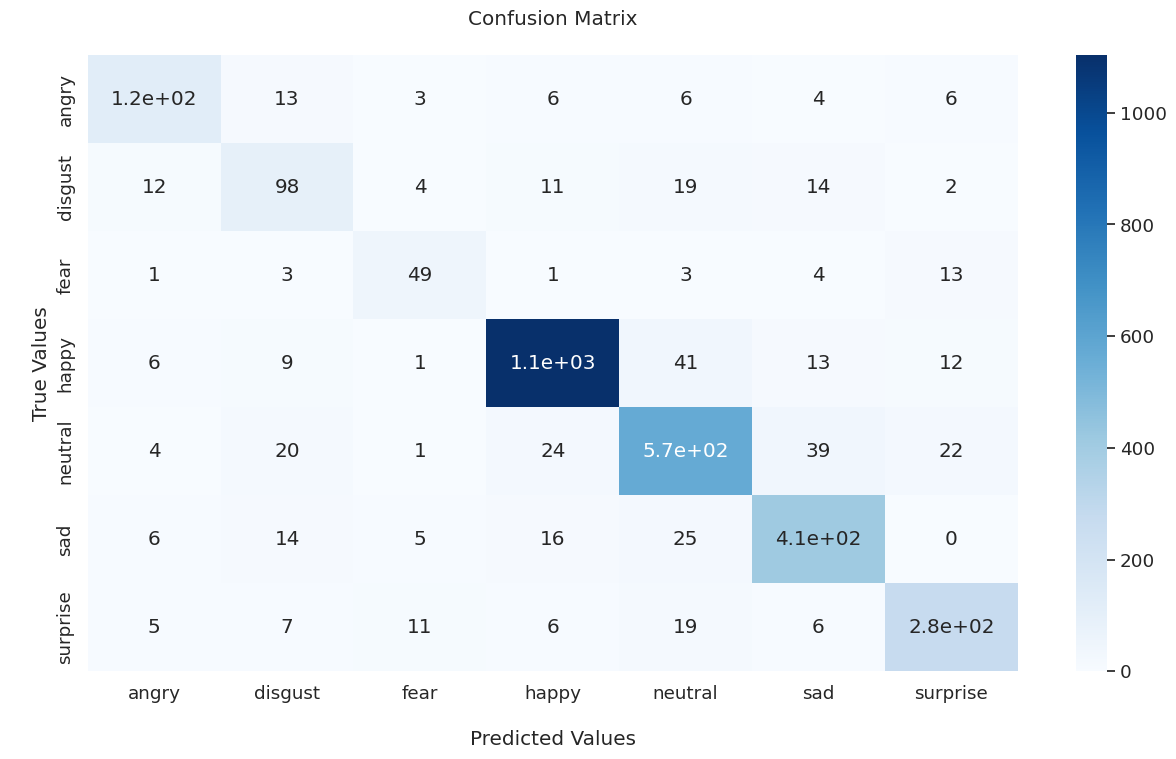

In [ ]:
plt.figure(figsize=(15,8))
ax = sns.heatmap(c_mat, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('\nTrue Values');
ax.xaxis.set_ticklabels(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
ax.yaxis.set_ticklabels(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
plt.show()

Как можно заметить, в целом модель справляется хорошо. А больше всего она путает классы happy и neutral, neutral и sad.